<a href="https://colab.research.google.com/github/yoly2020/ocr_test_project/blob/main/OCR1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import mnist
import sklearn
from tensorflow import keras
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use("Agg")

In [ ]:
!

In [ ]:
print("tensorflow version: ",tf.__version__)
print("numpy version: ",np.__version__)
print("keras version: ",keras.__version__)
print("sklearn version: ",sklearn.__version__)
print("pandas version: ",pd.__version__)
print("matplotlib version: ",matplotlib.__version__)

tensorflow version:  2.3.0
numpy version:  1.18.5
keras version:  2.4.0
sklearn version:  0.22.2.post1
pandas version:  1.1.2
matplotlib version:  3.2.2


In [6]:
(x1_train, y1_train), (x1_test, y1_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [7]:
mnist_x=np.vstack([x1_train,x1_test])
mnist_y=np.hstack([y1_train,y1_test])
print(mnist_x.shape)
print(mnist_y.shape)

(70000, 28, 28)
(70000,)


In [10]:
import os
os.chdir('/content/gdrive/My Drive/OCR Project/Kaggle Handwritten Alphabets/')
kag_dataset=pd.read_csv('A_Z Handwritten Data.csv').astype('float32')
kag_dataset.rename(columns={'0':'label'},inplace=True)

In [11]:
kag_x=kag_dataset.drop('label',axis=1)
kag_y=kag_dataset['label']
print(kag_x.shape)
print(kag_y.shape)
print(kag_x.head())

(372450, 784)
(372450,)
   0.1  0.2  0.3  0.4  0.5  0.6  ...  0.643  0.644  0.645  0.646  0.647  0.648
0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0
1  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0
2  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0
3  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0
4  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0

[5 rows x 784 columns]


In [12]:
kag_x=kag_x.values.reshape(kag_x.shape[0],28,28).astype('float32')
kag_y=kag_y.values

In [ ]:
print(kag_x.shape)
print(kag_y.shape)

(372450, 28, 28)
(372450,)


In [13]:
X=np.vstack([mnist_x,kag_x])
kag_y+=10.0
y=np.hstack([mnist_y,kag_y])

In [ ]:
y2=pd.DataFrame(y)
print(y2.describe)
# y2 shows that we change the labels of Kaggle Alphabets from [0,25] to [10,35] 
# while remaining the labels of MNIST as [0,9]

<bound method NDFrame.describe of            0
0        5.0
1        0.0
2        4.0
3        1.0
4        9.0
...      ...
442445  35.0
442446  35.0
442447  35.0
442448  35.0
442449  35.0

[442450 rows x 1 columns]>


In [ ]:
# import sys
# sys.path.append('/content/gdrive/My Drive/OCR Project/Python Modules/customized_resnet_model')

In [1]:
# 自定义resnet

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import add
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

class ResNet:
	@staticmethod
	def residual_module(data, K, stride, chanDim, red=False,
		reg=0.0001, bnEps=2e-5, bnMom=0.9):
		
		shortcut = data

		bn1 = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(data)
		act1 = Activation("relu")(bn1)
		conv1 = Conv2D(int(K * 0.25), (1, 1), use_bias=False,
			kernel_regularizer=l2(reg))(act1)

		bn2 = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(conv1)
		act2 = Activation("relu")(bn2)
		conv2 = Conv2D(int(K * 0.25), (3, 3), strides=stride,
			padding="same", use_bias=False,
			kernel_regularizer=l2(reg))(act2)

		bn3 = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(conv2)
		act3 = Activation("relu")(bn3)
		conv3 = Conv2D(K, (1, 1), use_bias=False,
			kernel_regularizer=l2(reg))(act3)

		if red:
			shortcut = Conv2D(K, (1, 1), strides=stride,
				use_bias=False, kernel_regularizer=l2(reg))(act1)

		x = add([conv3, shortcut])

		return x

	@staticmethod
	def build(width, height, depth, classes, stages, filters,
		reg=0.0001, bnEps=2e-5, bnMom=0.9, dataset="cifar"):

		inputShape = (height, width, depth)
		chanDim = -1

		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1

		inputs = Input(shape=inputShape)
		x = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(inputs)
		x = Conv2D(filters[0], (3, 3), use_bias=False,
			padding="same", kernel_regularizer=l2(reg))(x)

		for i in range(0, len(stages)):
			stride = (1, 1) if i == 0 else (2, 2)
			x = ResNet.residual_module(x, filters[i + 1], stride,
				chanDim, red=True, bnEps=bnEps, bnMom=bnMom)

			for j in range(0, stages[i] - 1):
				x = ResNet.residual_module(x, filters[i + 1],
					(1, 1), chanDim, bnEps=bnEps, bnMom=bnMom)

		x = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(x)
		x = Activation("relu")(x)
		x = AveragePooling2D((8, 8))(x)

		x = Flatten()(x)
		x = Dense(classes, kernel_regularizer=l2(reg))(x)
		x = Activation("softmax")(x)

		model = Model(inputs, x, name="resnet")

		return model

In [ ]:
# from resnet import ResNet

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD # Stochastic Gradient Descent
from sklearn.preprocessing import LabelBinarizer # convert labels from integers to a vector in what is called one-hot encoding
from sklearn.model_selection import train_test_split # split out testing and training data sets
from sklearn.metrics import classification_report # print out a nicely formatted classification report
from imutils import build_montages # Writer: Adrian URL: https://github.com/jrosebr1/imutils
import matplotlib.pyplot as plt
import numpy as np
import argparse # parse command line arguments
from google.colab.patches import cv2
from google.colab.patches import cv2_imshow

In [15]:
EPOCHS=50 # number of epochs to train for
INIT_LR=1e-1 # initial learning rate
BS=64 # batch size 
# 之前是128, 出现了小高峰

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(X[0])
print(y[0]) # y是浮点数，最好能够转化为categorical？

5.0


In [ ]:
# resize the image size to be fit for the ResNet model architechture
X=[cv2.resize(item,(32,32)) for item in X]
X=np.array(X, dtype="float32")
# 还有一个问题，32x32大小的图片是否适合最后的识别大小？

In [ ]:
# add a channel to every image
# to make it compatible with the ResNet model in Keras/TensorFlow
X=np.expand_dims(X,axis=-1)

# scale the image intensity from [0,255] down to [0,1]
X/=255.0

In [ ]:
X.shape

(442450, 32, 32, 1)

In [16]:
# convert the labels from integers i.e. [0,35], to one-hot encoding vector
lb=LabelBinarizer()
y=lb.fit_transform(y)
class_counts=y.sum(axis=0) # sum up(by columns) total nunbers of different labels respectively

In [ ]:
print(class_counts)
print(class_counts.shape) 
print(y.shape)
print(y[0:10]) # show the first 10 one-hot encoding labels of our dataset

[ 6903  7877  6990  7141  6824  6313  6876  7293  6825  6958 13869  8668
 23409 10134 11440  1163  5762  7218  1120  8493  5603 11586 12336 19010
 57825 19341  5812 11566 48419 22495 29008  4182 10784  6272 10859  6076]
(36,)
(442450, 36)
[[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [ ]:
# calculate the weights of different classes
# in order to reduce the skew in data sets
class_weights={}
for i in range(0,len(class_counts)):
  class_weights[i]=class_counts.max()/class_counts[i]
  print(i,': ',class_weights[i])


0 :  8.376792698826597
1 :  7.340992763742541
2 :  8.272532188841202
3 :  8.097605377398123
4 :  8.473769050410317
5 :  9.15967052114684
6 :  8.409685863874346
7 :  7.928835870012341
8 :  8.472527472527473
9 :  8.310577752227651
10 :  4.169370538611291
11 :  6.671089063221043
12 :  2.4702037677816224
13 :  5.7060390763765545
14 :  5.0546328671328675
15 :  49.72055030094583
16 :  10.035577924331829
17 :  8.011221945137157
18 :  51.629464285714285
19 :  6.808548216178029
20 :  10.320364090665715
21 :  4.990937338166753
22 :  4.6875
23 :  3.0418200946870066
24 :  1.0
25 :  2.989762680316426
26 :  9.94924294562973
27 :  4.999567698426422
28 :  1.1942625828703608
29 :  2.5705712380529007
30 :  1.993415609487038
31 :  13.827116212338593
32 :  5.362110534124629
33 :  9.21954719387755
34 :  5.3250759738465785
35 :  9.51695194206715


In [ ]:
# split the data into 80% train and 20% test
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42) 
# 不需要shuffle（train_test_split中有这个参数）么？

In [ ]:
# use image generator from Keras to create more balanced data set, it can improve the results of ResNet
aug = ImageDataGenerator(
	rotation_range=10,
	zoom_range=0.05,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.15,
	horizontal_flip=False,
	fill_mode="nearest")


In [18]:
opt = SGD(lr=INIT_LR, decay=INIT_LR/EPOCHS) # optimizer for the ResNet model

In [19]:
model = ResNet.build(32, 32, 1, len(lb.classes_), (3, 3, 3), (64, 64, 128, 256), reg=0.0005)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
H = model.fit(
	aug.flow(X_train, y_train, batch_size=BS),
	validation_data=(X_test, y_test),
	steps_per_epoch=len(X_train) // BS,  
	epochs=EPOCHS,
	class_weight=class_weights,
	verbose=1)
# aug.flow: inline data augmentation
# validation_data: test input images and test labels
# stesps_per_epoch: how many batches are run per each pass of the full training data
# epochs: the number of complete passes through the full data set during training
# class_weight: weights due to the imbalance of data samples for of different classes in the training data
# verbose: shows a progress bar during the training
# //: 取整除 - 返回商的整数部分（向下取整）

Epoch 1/50
5530/5530 [==============================] - 126s 23ms/step - loss: 1.7225 - accuracy: 0.8796 - val_loss: 0.5672 - val_accuracy: 0.8907
Epoch 2/50
5530/5530 [==============================] - 126s 23ms/step - loss: 0.9601 - accuracy: 0.9304 - val_loss: 0.5461 - val_accuracy: 0.9040
Epoch 3/50
5530/5530 [==============================] - 126s 23ms/step - loss: 0.8858 - accuracy: 0.9360 - val_loss: 0.5592 - val_accuracy: 0.8920
Epoch 4/50
5530/5530 [==============================] - 126s 23ms/step - loss: 0.8466 - accuracy: 0.9393 - val_loss: 0.5155 - val_accuracy: 0.9088
Epoch 5/50
5530/5530 [==============================] - 126s 23ms/step - loss: 0.8213 - accuracy: 0.9411 - val_loss: 0.5219 - val_accuracy: 0.9073
Epoch 6/50
5530/5530 [==============================] - 125s 23ms/step - loss: 0.7979 - accuracy: 0.9440 - val_loss: 0.5139 - val_accuracy: 0.9063
Epoch 7/50
5530/5530 [==============================] - 126s 23ms/step - loss: 0.7864 - accuracy: 0.9443 - val_loss: 0

In [ ]:
labelNames="0123456789"
labelNames+="ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames=[l for l in labelNames]


In [ ]:
predictions = model.predict(X_test, batch_size=BS)
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames)) # from scikit-learn, axis indicates which part you want to operate
# U的support没有跟原文对上

              precision    recall  f1-score   support

           0       0.63      0.37      0.46      1381
           1       0.98      0.99      0.98      1575
           2       0.94      0.95      0.94      1398
           3       0.98      0.99      0.99      1428
           4       0.94      0.97      0.95      1365
           5       0.70      0.94      0.80      1263
           6       0.97      0.97      0.97      1375
           7       0.97      0.99      0.98      1459
           8       0.97      0.99      0.98      1365
           9       0.99      0.98      0.98      1392
           A       0.99      0.99      0.99      2774
           B       0.98      0.99      0.99      1734
           C       0.99      0.99      0.99      4682
           D       0.89      0.98      0.94      2027
           E       0.99      0.99      0.99      2288
           F       0.97      0.99      0.98       232
           G       0.97      0.96      0.96      1152
           H       0.98    

In [ ]:
print(y_test.argmax(axis=1))
print(y_test)
print(predictions)
print(y_test.shape)
print(predictions.argmax(axis=1))

[24 35 29 ... 24 12 24]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[9.1394290e-02 4.3805409e-07 1.8422357e-06 ... 1.5422577e-08
  4.8954458e-08 1.0199755e-07]
 [2.5471754e-08 9.4790028e-07 5.6180870e-04 ... 3.4651416e-07
  8.5996890e-09 9.9898309e-01]
 [7.7013969e-09 8.3216109e-06 8.6671585e-09 ... 1.2600886e-07
  1.3836799e-06 9.7261573e-06]
 ...
 [2.4597453e-01 3.4518180e-07 8.8311610e-04 ... 1.8535761e-07
  6.4216636e-07 3.3734216e-06]
 [6.0803177e-05 2.2917821e-07 2.6183259e-05 ... 5.2177284e-06
  6.0908881e-08 2.4004839e-04]
 [5.0580548e-03 3.7052075e-07 9.0063739e-05 ... 1.9606679e-08
  3.6370963e-07 1.2126671e-08]]
(88490, 36)
[24 35 29 ... 24 12 24]


In [ ]:
print(predictions.shape)
print(y_test.shape)
print(predictions.argmax(axis=1).shape)

(88490, 36)
(88490, 36)
(88490,)


In [ ]:
#  save models
model.save(filepath='/content/gdrive/My Drive/OCR Project/My_OCR_Model/my_model_2.h5',save_format="h5")

In [ ]:
# save pictures of loss
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss") # loss is the error evaluated during training a model, val_loss is the error during validation
plt.plot(N, H.history["val_loss"], label="val_loss") # Loss is calculated base on the train set, val_loss is calculated base on the validation set
# If you have loss noticeably lower than val_loss it is the sign of overfitting
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('/content/gdrive/My Drive/OCR Project/My_OCR_Model/2.png')

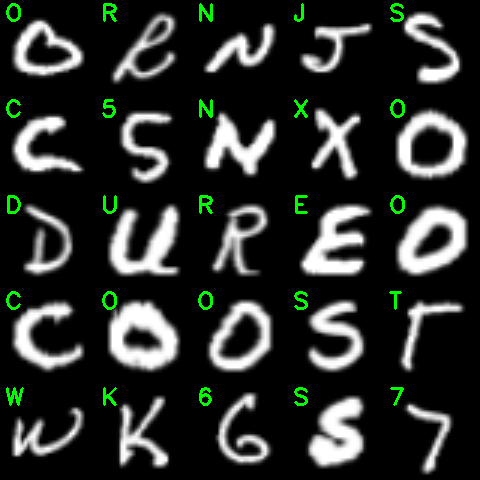

-1

In [ ]:
output_img=[]

pred_list=[]

# randomly pick 64 testing characters to form 8x8 grid
for i in np.random.choice(np.arange(0,len(y_test)),size=(25,)):
  predict_probs=model.predict(X_test[i:i+10])
  prediction=predict_probs.argmax(axis=1)
  label=labelNames[prediction[0]]
  pred_list.append(prediction[0])

  image=(X_test[i]*255).astype("uint8")
  label_color=(0,255,0) # make the correct class label green

  if prediction[0]!= np.argmax(y_test[i]):
    label_color=(0,0,255)
  
  image=cv2.merge([image]*3) # merge 3 channels
  image=cv2.resize(image,(96,96),interpolation=cv2.INTER_LINEAR) # resize the image for clear output
  cv2.putText(img=image, text=label, org=(5,20), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.75, color=label_color, thickness=2)

  output_img.append(image)

montage=build_montages(output_img,(96,96),(5,5))[0]

cv2_imshow(montage)
cv2.waitKey(0)


(5, 32, 32, 1)
(32, 32, 1)
(32, 32, 1)


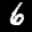

(88490, 32, 32, 1)
(10,)
1
[22, 10, 23, 24, 19, 30, 29, 23, 2, 24, 33, 24, 13, 23, 3, 23, 24, 24, 5, 34, 24, 12, 24, 24, 32]


In [ ]:
print(X_test[np.newaxis:5].shape)
print(X_test[5].shape)
print(X_test[np.newaxis:5][0].shape)
cv2_imshow(X_test[5]*255)
print(X_test.shape)
print(prediction.shape)

if X_test[np.newaxis:5][0].all() == X_test[np.newaxis:8][0].all():
  print(1)

print(pred_list)

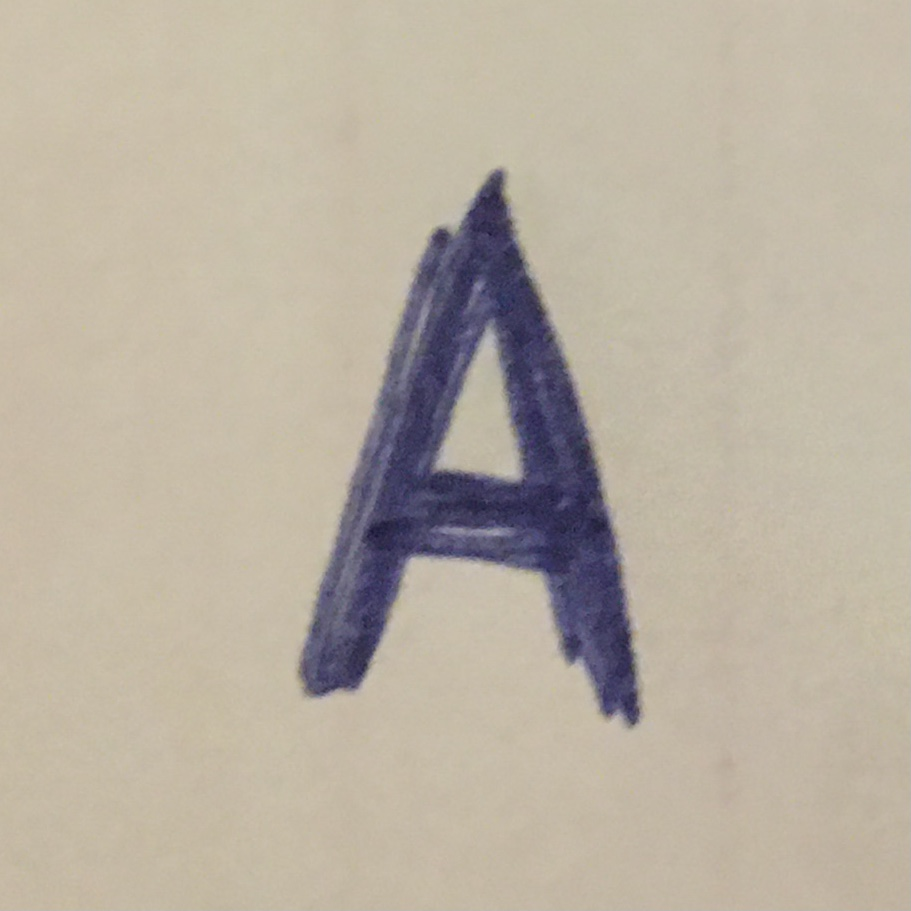

In [20]:
hand_img_name='/content/gdrive/My Drive/OCR Project/A1.jpg'
hand_img=cv2.imread(hand_img_name)
cv2_imshow(hand_img)

(911, 911)


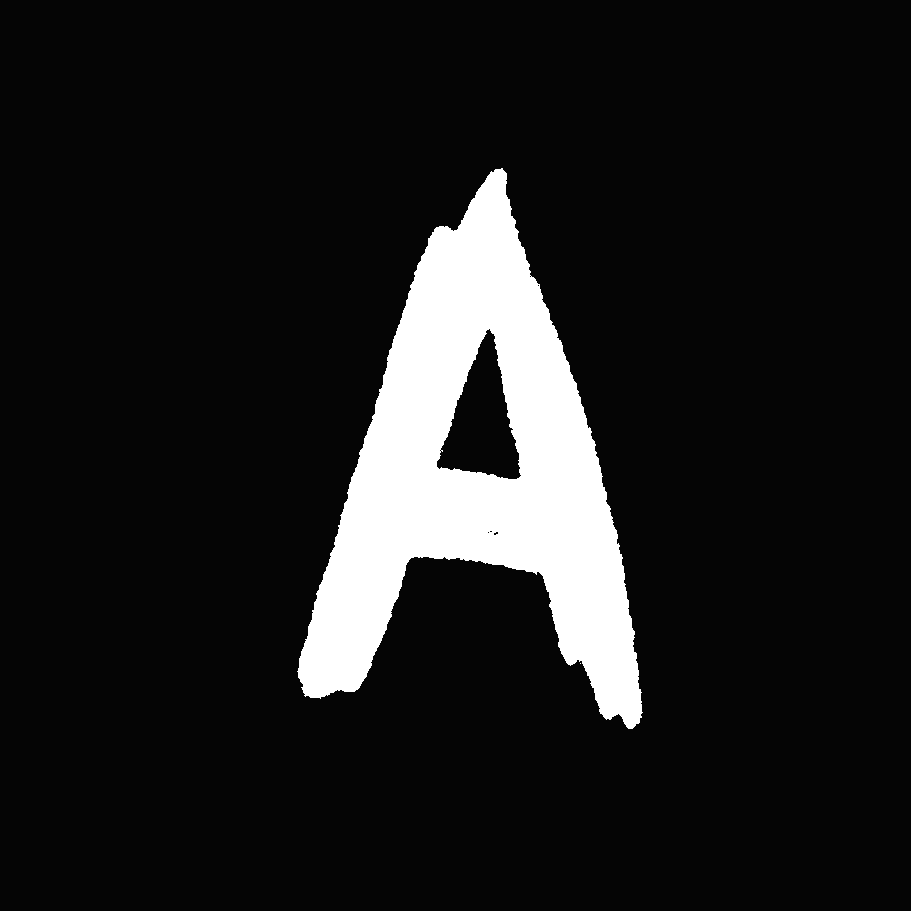

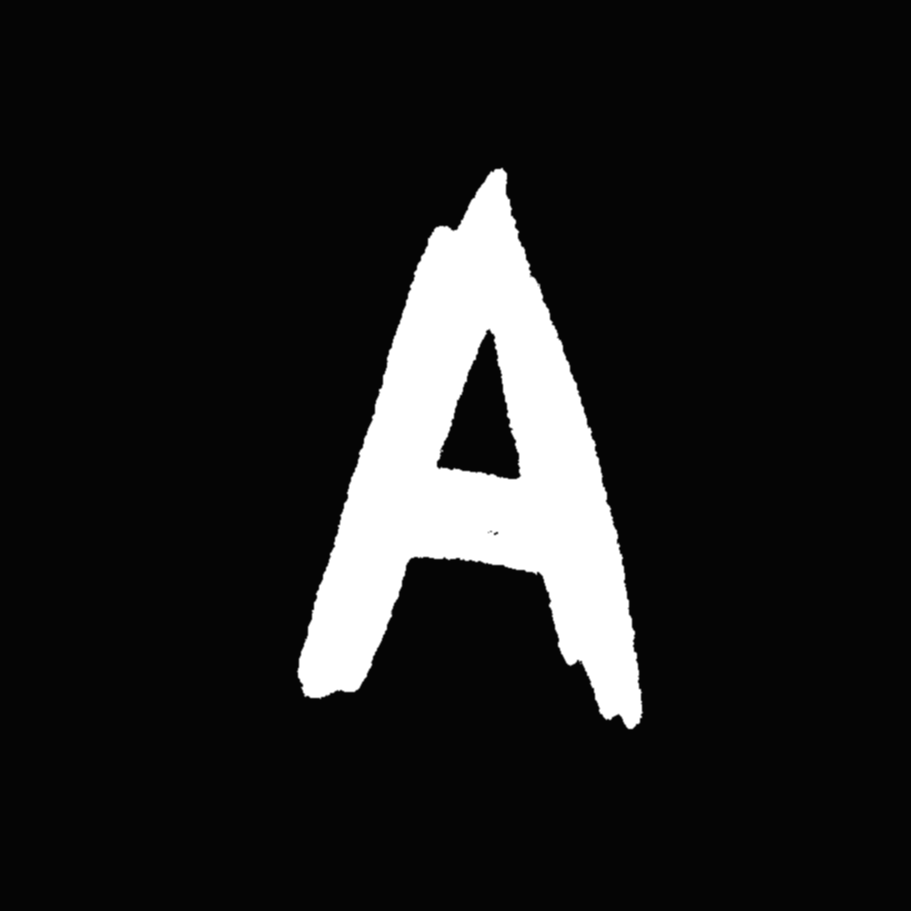

In [ ]:
grey_hand_img=cv2.cvtColor(hand_img,cv2.COLOR_BGR2GRAY)
# cv2_imshow(grey_hand_img)
neg_img=255.0-grey_hand_img
print(grey_hand_img.shape)
# cv2_imshow(neg_img)
ret,thre=cv2.threshold(neg_img,100,250,cv2.THRESH_BINARY_INV)
# cv2_imshow(thre)
neg_thre=255.0-thre
cv2_imshow(neg_thre)
neg_thre_blur=cv2.GaussianBlur(neg_thre,(3,3),0)
cv2_imshow(neg_thre_blur)

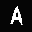

In [ ]:
hand_img=cv2.resize(neg_thre_blur,(32,32))
cv2_imshow(hand_img)

In [ ]:
img_list=np.asarray([hand_img],dtype='float32')
img_list/=255.0

In [ ]:
img_list=np.expand_dims(img_list,axis=-1)
print(img_list.shape)

(1, 32, 32, 1)


In [ ]:
print(X_test[0:1].shape)

(1, 32, 32, 1)


In [ ]:
predict_probs_hand=model.predict(img_list)
pred_results_hand=predict_probs_hand.argmax(axis=1)
print(pred_results_hand)
label=labelNames[pred_results_hand[0]]
print(label)

[10]
A
